In [1]:
# Data Loading and Exploring
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from joblib import load
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Performance Measurement Metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Custom Modules
from utils.data_preprocessing import preprocess_crime_data

# Filter out Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Location of stored dataset
dataset_path = Path('../datasets/chicago-crime-data.csv')

if dataset_path.exists():
    print(f"File found: {dataset_path.name}")
else:
    load_crime_dataset()

File found: chicago-crime-data.csv


In [3]:
crime_df = pd.read_csv(dataset_path)
crime_df['date'] = pd.to_datetime(crime_df['date'])

In [4]:
X, Y = preprocess_crime_data(crime_df)

Dataset Shape: (1408934, 22)
Duplicated rows detected: 0
Missing Values: 102057


In [5]:
# Assuming you have your features in X and labels in y
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Random Forest CV

In [6]:
def rf_auc(model, X_test, y_test):
    """
    Calculate precision, recall, and AUC for a given model and test dataset.

    Parameters:
        model: Trained model with a predict method.
        X_test: Features of the test dataset.
        y_test: Tr
        ue labels of the test dataset.

    Returns:
        precision: Precision values.
        recall: Recall values.
        auc_score: Area under the Precision-Recall curve.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate precision, recall, and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_score = auc(recall, precision)
    
    return precision, recall, auc_score

In [7]:
rf_path = Path('../model-reports/random_forest_model.pkl')
rf_classifier = load(rf_path)

In [8]:
# creating RepeatedStratifiedKFold 
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)

# Slice the numpy arrays directly
X_val = X_val[1:10000]
y_val = y_val[1:10000]

# Performing Cross-Validation
k_scores = cross_val_score(rf_classifier, X_val, y_val, scoring='accuracy', cv=cross_validation)

# Accuracy Score
print('Accuracy_mean',np.mean(k_scores))

Accuracy_mean 0.8541186853520185


In [9]:
# Call the function
precision_rf, recall_rf, area_rf = rf_auc(rf_classifier, X_test, y_test)

# Print results
print("AUC:", area_rf)

AUC: 0.5428767107630761


### Neural Network CV

In [10]:
def nn_auc(model, X_test, y_test):
    """
    Calculate precision, recall, and AUC for a given neural network model and test dataset.

    Parameters:
        model: Trained model with a predict method.
        X_test: Features of the test dataset.
        y_test: True labels of the test dataset.

    Returns:
        precision: Precision values.
        recall: Recall values.
        auc_score: Area under the Precision-Recall curve.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # In case of multi-class classification, take the class with highest probability
    y_pred_class = np.argmax(y_pred, axis=1)
    
    # Calculate precision, recall, and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_class)
    auc_score = auc(recall, precision)
    
    return precision, recall, auc_score

In [14]:
nn_path = Path('../model-reports/neural_network_model.keras')
nn_classifier = load_model(nn_path)

In [12]:
# Define your neural network model
def create_model():
    model = Sequential()
    # Add layers and compile the model as needed
    # For example:
    model.add(Dense(128, activation='relu', input_shape=(X_val.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap your Keras model with KerasClassifier
nn_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0)

# Set up cross-validation strategy
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)

# Slice the numpy arrays directly
X_val = X_val[1:10000]
y_val = y_val[1:10000]

# Perform cross-validation
k_scores = cross_val_score(nn_classifier, X_val, y_val, scoring='accuracy', cv=cross_validation)

# Output the results
print('Accuracy_mean', np.mean(k_scores))

Accuracy_mean 0.8978804804804806


In [15]:
# Call the function
precision_nn, recall_nn, area_nn = nn_auc(nn_classifier, X_test, y_test)

# Print results
print("AUC:", area_nn)

6489/6489 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
AUC: 0.5664891963494705


### AUPRC

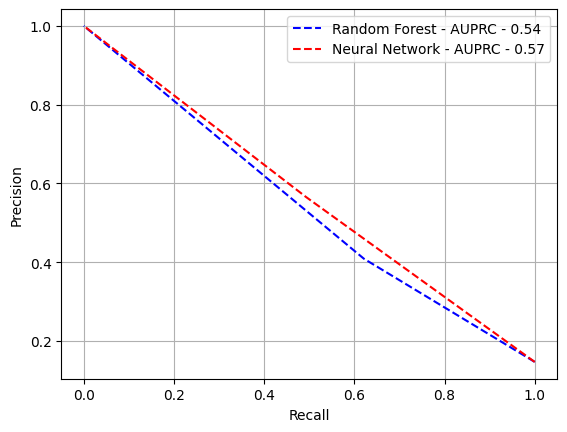

In [16]:
plt.plot(recall_rf, precision_rf, linestyle="--", color='b', label='Random Forest - AUPRC - ' + str(area_rf.round(2)))
plt.plot(recall_nn, precision_nn, linestyle="--", color='r', label='Neural Network - AUPRC - ' + str(area_nn.round(2)))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()